# Fixing a Corrupted Model
```In this exercise you will experience with "debugging" a model. You will analyze the datasets and the differences between them and the problems in the training process of the model.```

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.rcParams['figure.figsize'] = 12,7

```Here you will explore a trained model and see where, and more interestingly, why, it fails.```

- ```Completion Rate (CR) is the the percentage of orders that were completed successfully. You have a model that predicts this measurement in Kazan, a city in Russia```
- ```Attached to this notebook are two files: `train.csv` and `test.csv` ```
- ```A model to predict CR (`cr_guas`) was trained on `train.csv` (`DataAnalyst-Model.ipynb`) and saved into `model.pkl` ```
- ```Your task is to analyze the model results and find out if there are any issues with it```
- ```Please answer the questions below```
- ```Provide proofs in the form of statistics and plots```
- ```Write your own conclusion about the results and your suggestions for a solution```
- ```There are at least two major problems, and some other minor problems```

# Load Data

In [2]:
df_train = pd.read_csv('resources/train.csv', encoding='utf-8')
df_test = pd.read_csv('resources/test.csv', encoding='utf-8')

In [60]:
df_train.sample(5)

,sample_t,area,weekday,weekdaycat,hour,hourcat,cos604800,sin604800,cr_weight,cr_gaus,cr_mean
73681,1522256700,Kazan улица Воровского,2.711806,NaN,17.083333,17,0.966728,-0.255807,0.629354,1.00000,0.628231
4834,1521120600,Kazan улица Патриса Лумумбы,3.562500,NaN,13.500000,13,0.875223,0.483719,22.786867,0.77061,0.572180
101505,1522395000,Kazan проспект Фатыха Амирхана,4.312500,NaN,7.500000,7,0.382683,0.923880,23.267983,0.93160,0.830634
51801,1520789100,Kazan Сибирский Tракт 2,6.725694,NaN,17.416667,17,-0.979550,-0.201200,7.306992,0.46454,0.386830
21392,1521093600,Kazan Аэропорт Казань,3.250000,6.0,6.000000,6,0.974928,0.222521,0.619839,1.00000,0.939975


# Load model

In [3]:
from lightgbm import LGBMRegressor
from sklearn.externals import joblib

In [4]:
lgb = joblib.load('resources/model.pkl')

In [5]:
features = lgb.booster_.feature_name()
features

[u'area',
 u'weekday',
 u'weekdaycat',
 u'hour',
 u'hourcat',
 u'cos604800',
 u'sin604800',
 u'cr_mean']

In [6]:
df_train['area'] = df_train['area'].astype('category')
df_train['weekdaycat'] = df_train['weekdaycat'].astype('category')
df_train['hourcat'] = df_train['hourcat'].astype('category')

df_test['area'] = df_test['area'].astype(df_train['area'].dtype)
df_test['weekdaycat'] = df_test['weekdaycat'].astype(df_train['weekdaycat'].dtype)
df_test['hourcat'] = df_test['hourcat'].astype(df_train['hourcat'].dtype)

In [7]:
df_train['cr_pred'] = lgb.predict(df_train[features])
df_test['cr_pred'] = lgb.predict(df_test[features])

# Results

Please analyze and compare the MAE of the predictions

1. Is there any diffence between train\test? Why?
2. Is there any diffrence between areas? If so, why?
3. The PM still thinks there is a problem with our prediction... I can't find any problem, Can you? Find as many as you can!

**Don't forget plots**

# Exploring the problem

### orgenizing the data

In [10]:
import googletrans
translator = googletrans.Translator()
dict_ru_to_en = dict(map(lambda area: (area, translator.translate(area, dest='en', src='ru').text),
                         set(df_train['area']).union(set(df_test['area']))))

In [63]:
df_train['area'] = df_train['area'].apply(lambda x: dict_ru_to_en[x])
df_test['area'] = df_test['area'].apply(lambda x: dict_ru_to_en[x])

dict_en_to_numeric = dict(enumerate(list(set(df_train['area']).union(set(df_test['area'])))))
dict_en_to_numeric = {v:k for k,v in dict_en_to_numeric.iteritems()}
df_train['area_numeric'] = df_train['area'].apply(lambda x: dict_en_to_numeric[x])
df_test['area_numeric'] = df_test['area'].apply(lambda x: dict_en_to_numeric[x])

df_train['source'] = 'train'
df_test['source'] = 'test'
df_train['area_numeric'] = df_train['area_numeric'].astype(float)
df_test['area_numeric'] = df_test['area_numeric'].astype(float)
df = pd.concat([df_train, df_test], axis = 0)

### features histogram

In [92]:
features

[u'area',
 u'weekday',
 u'weekdaycat',
 u'hour',
 u'hourcat',
 u'cos604800',
 u'sin604800',
 u'cr_mean']

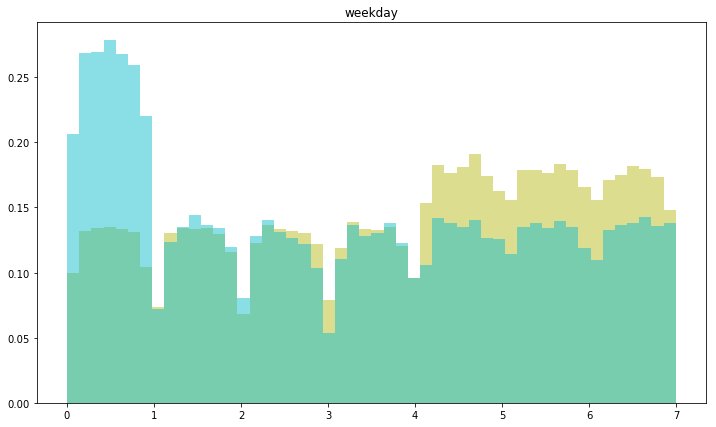

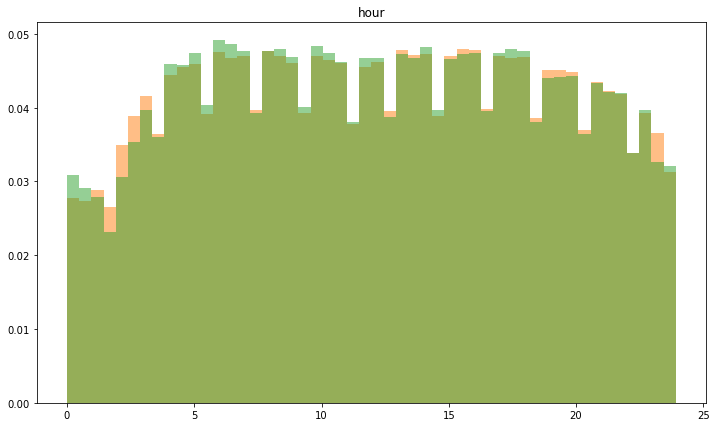

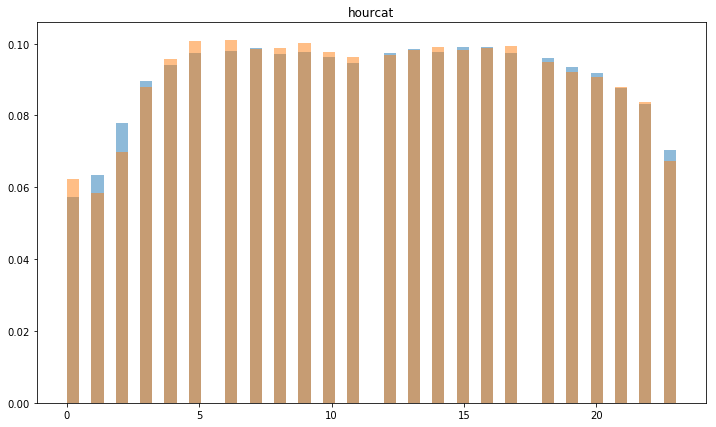

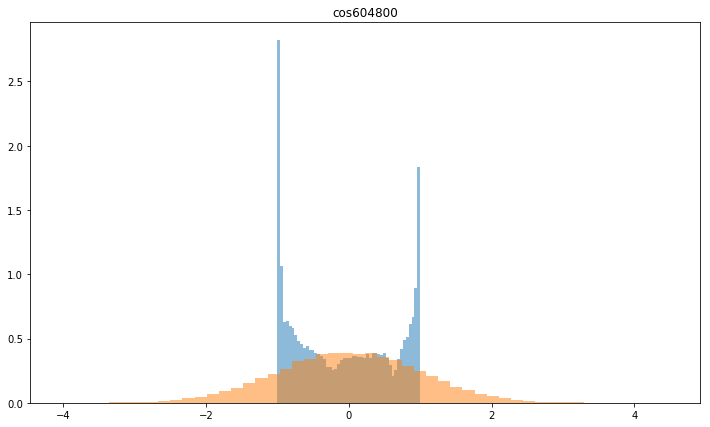

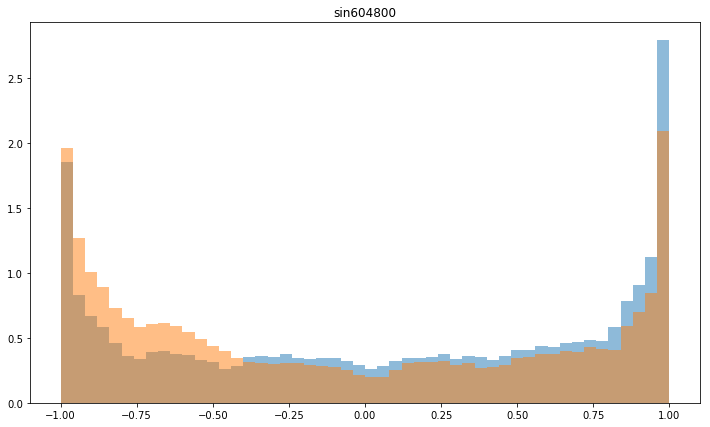

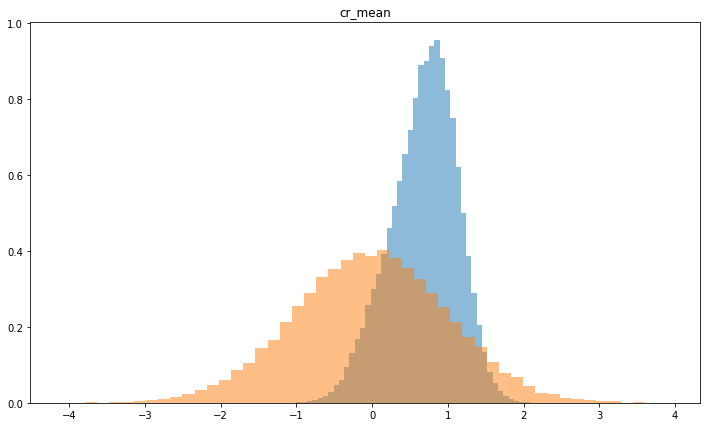

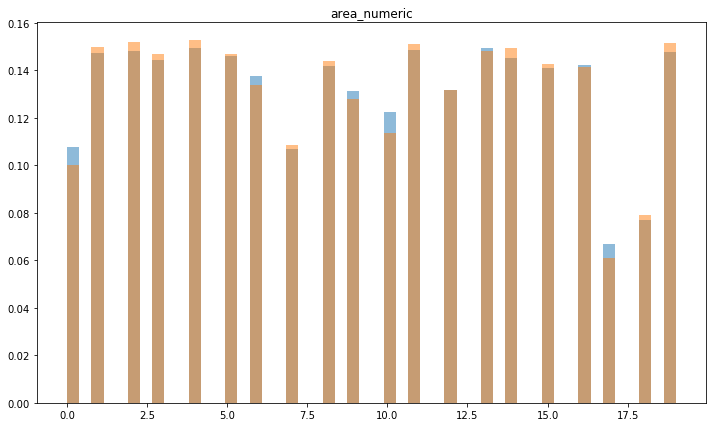

In [12]:
from seaborn import violinplot
for col in features+['area_numeric']:
    try:
        plt.title(col)
        plt.hist(df_train[col], bins = 50, alpha = 0.5, normed = True)
        plt.hist(df_test[col], bins = 50, alpha = 0.5, normed = True)
        plt.show()
    except:
        pass

### feature importance

In [22]:
sorted(zip(features, lgb.feature_importances_), key = lambda x: -x[1])

[(u'cr_mean', 621),
 (u'hour', 585),
 (u'area', 496),
 (u'weekday', 450),
 (u'sin604800', 400),
 (u'cos604800', 357),
 (u'hourcat', 346),
 (u'weekdaycat', 45)]

### cliping the predictions

In [64]:
print(mean_absolute_error(df_train['cr_gaus'], df_train['cr_pred']))
print(mean_absolute_error(df_test['cr_gaus'], df_test['cr_pred']))

0.112486942877
0.30727150108


In [65]:
print(mean_absolute_error(df_train['cr_gaus'], np.clip(df_train['cr_pred'], 0, 1)))
print(mean_absolute_error(df_test['cr_gaus'], np.clip(df_test['cr_pred'], 0, 1)))

0.111579360927
0.305869306623


### predictions vs reality, train and test

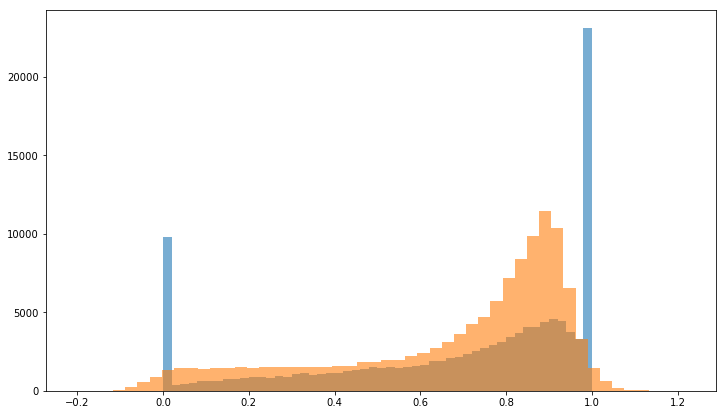

In [19]:
plt.hist(df_train['cr_gaus'], bins = 50, alpha = 0.6)
plt.hist(df_train['cr_pred'], bins = 50, alpha = 0.6)
plt.show()

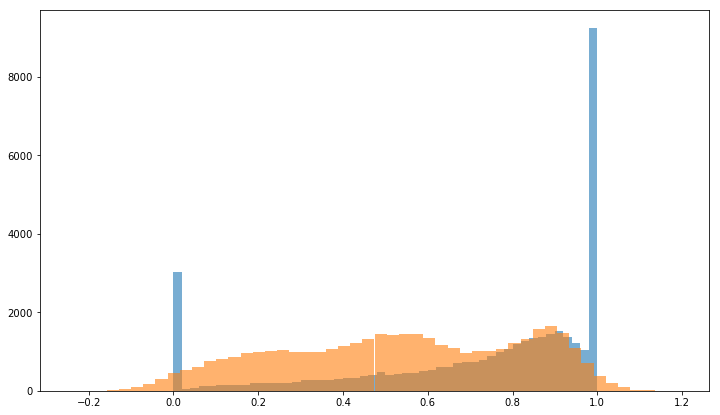

In [20]:
plt.hist(df_test['cr_gaus'], bins = 50, alpha = 0.6)
plt.hist(df_test['cr_pred'], bins = 50, alpha = 0.6)
plt.show()

### area distribution

In [27]:
all_areas = list(set(df['area']))

from collections import Counter
def normalized_counter(vector):
    counter = Counter(vector)
    summer = sum(map(lambda x: x[1], counter.most_common()))
    return sorted(map(lambda x: (x[0], x[1]/float(summer)), counter.most_common()), key = lambda x: x[0])

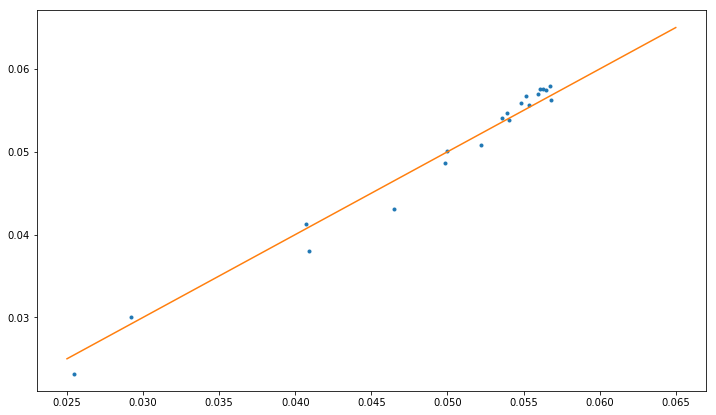

In [34]:
plt.plot(map(lambda x: x[1], normalized_counter(df_train['area'])),
         map(lambda x: x[1], normalized_counter(df_test['area'])), '.')
plt.plot(np.arange(0.025, 0.07, 0.005), np.arange(0.025, 0.07, 0.005))
plt.show()

# Problems found

### fixing the cos604800 feature

In [84]:
print(mean_absolute_error(df_test['cr_gaus'], df_test['cr_pred']))

0.30727150108


0.328013117154
0.324657515248


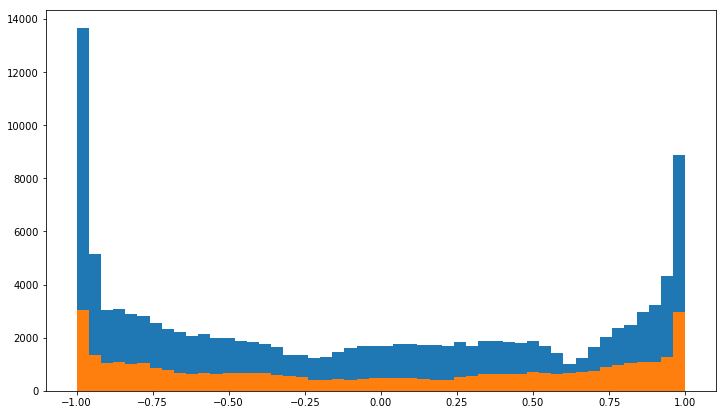

In [91]:
A = df_test[features].copy()
A['cos604800'] = np.clip(A['cos604800'], -1, 1)
print(mean_absolute_error(lgb.predict(A[features]), df_test['cr_gaus']))

A = df_test[features].copy()
A['cos604800'] = np.random.choice([-1,1], len(A))*np.cos(np.arcsin(A['sin604800']))
print(mean_absolute_error(lgb.predict(A[features]), df_test['cr_gaus']))

plt.hist(df_train['cos604800'], bins = 50)
plt.hist(A['cos604800'], bins = 50)
plt.show()

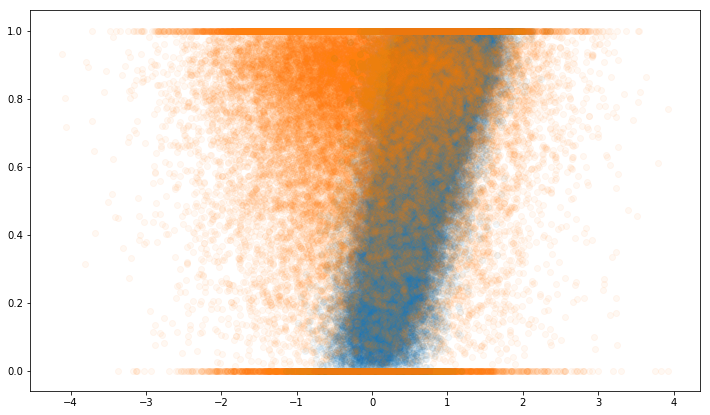

correlation between cr_mean and the target in train: 0.727105722091
correlation between cr_mean and the target in test: 0.00673379800501


In [162]:
plt.scatter(df_train['cr_mean'], df_train['cr_gaus'], alpha = 0.05)
plt.scatter(df_test['cr_mean'], df_test['cr_gaus'], alpha = 0.05)
plt.show()
print('correlation between cr_mean and the target in train: ' + str(np.corrcoef(df_train['cr_mean'], df_train['cr_gaus'])[0][1]))
print('correlation between cr_mean and the target in test: ' + str(np.corrcoef(df_test['cr_mean'], df_test['cr_gaus'])[0][1]))

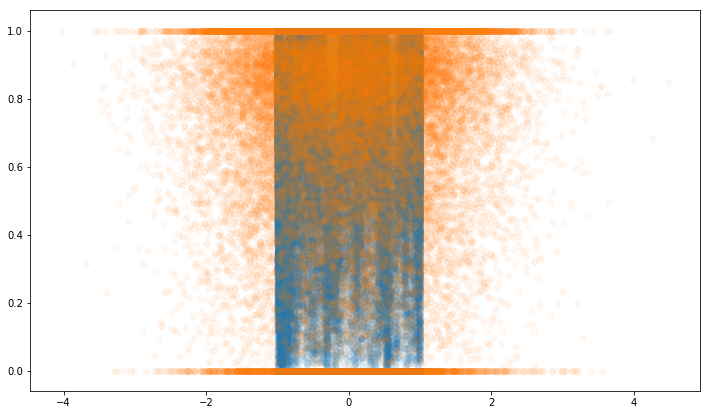

correlation between cr_mean and the target in train: 0.099850256373
correlation between cr_mean and the target in test: 0.00224774699707


In [70]:
plt.scatter(df_train['cos604800'], df_train['cr_gaus'], alpha = 0.05)
plt.scatter(df_test['cos604800'], df_test['cr_gaus'], alpha = 0.05)
plt.show()
print('correlation between cr_mean and the target in train: ' + str(np.corrcoef(df_train['cos604800'], df_train['cr_gaus'])[0][1]))
print('correlation between cr_mean and the target in test: ' + str(np.corrcoef(df_test['cos604800'], df_test['cr_gaus'])[0][1]))

```I found a problem with two features, while cr_mean is the most important feature. It seems that those features were simply replaced by normal distribution.```

In [10]:
features_corrupted = ['cos604800', 'cr_mean']
features_not_corrupted = [i for i in features if not i in features_corrupted]

In [102]:
from sklearn.model_selection import train_test_split
ok_train, ok_test, ok_target_train, ok_target_test = train_test_split(df_train[features_not_corrupted],
                                                                      df_train[features_corrupted],
                                                                      train_size=0.7, test_size=0.3)

In [135]:
clf_cos = LGBMRegressor(n_estimators=1000, max_depth=8, colsample_bytree=0.7, subsample=0.4)
clf_cos.fit(ok_train, ok_target_train['cos604800'])
print(mean_squared_error(clf_cos.predict(ok_train), ok_target_train['cos604800']))
print(mean_squared_error(clf_cos.predict(ok_test), ok_target_test['cos604800']))

9.84899724144e-06
1.36355679085e-05


In [168]:
clf_cr_mean = LGBMRegressor(n_estimators=500, max_depth=15, colsample_bytree=0.7, subsample=0.8)
clf_cr_mean.fit(ok_train, ok_target_train['cr_mean'])
print(mean_squared_error(clf_cr_mean.predict(ok_train), ok_target_train['cr_mean']))
print(mean_squared_error(clf_cr_mean.predict(ok_test), ok_target_test['cr_mean']))

0.129509588647
0.1418948965


In [165]:
A = df_test.copy()
A['cos604800'] = clf_cos.predict(A[features_not_corrupted])
# A['cos604800'] = np.sign(clf_cos.predict(A[features_not_corrupted]))*np.cos(np.arcsin(A['sin604800']))
A['cr_mean'] = clf_cr_mean.predict(A[features_not_corrupted])
print(mean_absolute_error(np.clip(lgb.predict(A[features]), 0, 1), df_test['cr_gaus']))

0.211792750134


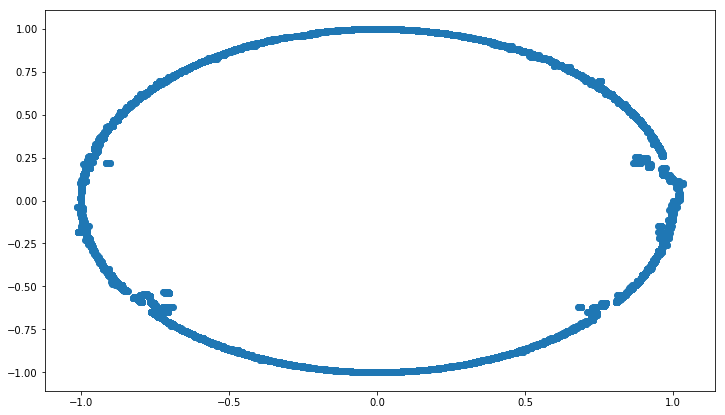

In [150]:
plt.scatter(A['cos604800'], A['sin604800'])
plt.show()

In [ ]:
plt.hist()

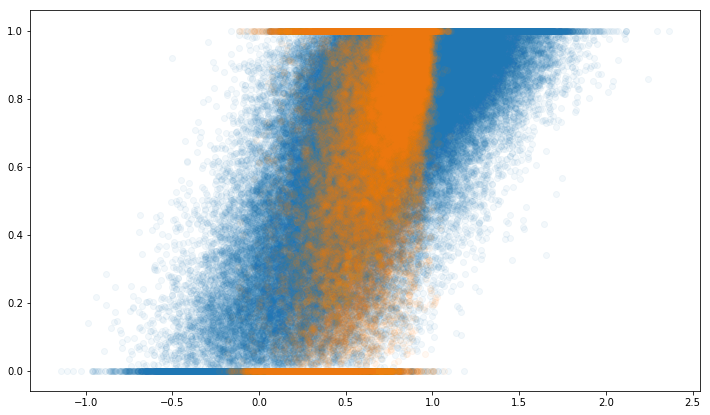

correlation between cr_mean and the target in train: 0.099850256373
correlation between cr_mean and the target in test: 0.00224774699707


In [152]:
plt.scatter(df_train['cr_mean'], df_train['cr_gaus'], alpha = 0.05)
# plt.scatter(df_test['cr_mean'], df_test['cr_gaus'], alpha = 0.05)
plt.scatter(A['cr_mean'], A['cr_gaus'], alpha = 0.05)
plt.show()
print('correlation between cr_mean and the target in train: ' + str(np.corrcoef(df_train['cos604800'], df_train['cr_gaus'])[0][1]))
print('correlation between cr_mean and the target in test: ' + str(np.corrcoef(df_test['cos604800'], df_test['cr_gaus'])[0][1]))

## Seperating train and test

In [38]:
from sklearn.utils import shuffle

df_train_dummy = df_train[features_not_corrupted].copy()
df_train_dummy['source'] = 0
df_test_dummy = df_test[features_not_corrupted].copy()
df_test_dummy['source'] = 1
df = pd.concat([df_train_dummy, df_test_dummy], axis = 0)
df = shuffle(df)

In [23]:
from lightgbm import LGBMClassifier

In [65]:
determiner = LGBMClassifier(max_depth=7, n_estimators=200, subsample=0.9, colsample_bytree=0.8, class_weight='balanced')
determiner.fit(df[:int(0.7*len(df))][features_not_corrupted], df[:int(0.7*len(df))]['source'])

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

print('train f1_score: ' + str(f1_score(determiner.predict(df[:int(0.7*len(df))][features_not_corrupted]), df[:int(0.7*len(df))]['source'])))
print('test f1_score: ' + str(f1_score(determiner.predict(df[int(0.7*len(df)):][features_not_corrupted]), df[int(0.7*len(df)):]['source'])))

conf = confusion_matrix(determiner.predict(df[int(0.7*len(df)):][features_not_corrupted]), df[int(0.7*len(df)):]['source'])
conf = conf/np.sum(conf, axis = 1).astype(float).reshape(-1,1)
conf

train f1_score: 0.546597947894
test f1_score: 0.49636635869


array([[ 0.8433525 ,  0.1566475 ],
       [ 0.56052768,  0.43947232]])

In [66]:
sorted(list(zip(features_not_corrupted, determiner.feature_importances_), key= lambda x: -x[1]))

[(u'sin604800', 1744),
 (u'hour', 1338),
 (u'weekday', 1236),
 (u'area', 1071),
 (u'hourcat', 504),
 (u'weekdaycat', 107)]

```It doesn't seem like the dataframes are drawn from different distributions.```

### summarization of possible problems:
- ```there are minor distribution shifts in some features, as can be seen in the graphs above.```
- ```cos604800 and cr_mean were replaces with np.random.normal(0,1,size)```
- ```cos604800 can be predicted from the rest of the data. It is then easy to notice that together with sin604800 they are supposed to form a circle. We can make the right adjustments to get a circle.```